# Assignment 3: Example-dependent Cost-Sensitive Logistic Regression

| Name             | Roll Number       |
|------------------|-------------------|
| **Popat Raj R**  | CS23MTECH14009    |
| **Yash Shukla**  | CS23MTECH14018    |
| **Vaibhav Shah** | AI23MTECH02007    |
| **Sreyash Mohanty** | CS23MTECH14015  |
| **Somya Kumar** | SM23MTECH11010  |

## Overview
This notebook presents an example-dependent cost-sensitive approach to logistic regression, Bahnsen approach, Nikou Gunnemann's approach


In [ ]:
import pandas as pd
from rich.console import Console
from PIL import Image, ImageDraw, ImageFont
import textwrap

In [ ]:
file_path = "costsensitiveregression.csv"

Mounted at /content/drive


In [ ]:
# Load the dataset
df = pd.read_csv(file_path)
df.head()

,NotCount,YesCount,ATPM,PFD,PFG,SFD,SFG,WP,WS,AH,AN,Status,FNC
0,2,21,0.0,0.000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0,0.0
1,23,0,0.0,0.044,0.0,0.0,0.0,0.306179,0.0,0.0,0.0,1,0.0
2,1,22,0.0,0.000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0,0.0
3,5,18,0.0,0.000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,1,0.0
4,1,22,0.0,0.000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0,0.0


In [ ]:
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from sklearn.model_selection import train_test_split

X = df.drop(labels = ['Status'], axis = 1)
y = df['Status'].copy()

# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=14009)

# Dataset Loader for Cost-Sensitive Learning

The `DatasetLoader` class is a custom dataset handler designed for use with PyTorch models, particularly for scenarios requiring cost-sensitive learning. This class is part of the `torch.utils.data.Dataset` family and is tailored to manage datasets that include different cost factors associated with the prediction outcomes.

## Key Features and Methods:

### Initialization (`__init__`)
- **Purpose**: Sets up the dataset by initializing features, labels, and various costs from a pandas DataFrame.
- **Parameters**:
  - `data_frame`: Contains feature values and specific cost values.
  - `target`: Contains the target labels for the dataset.
- **Behavior**:
  - Features are extracted from the DataFrame, excluding any non-feature columns like 'FNC'.
  - Labels and the cost for false negatives ('FNC') are also stored.
  - Costs for true positives, true negatives, and false positives are set as fixed values within the class.

### Length Determination (`__len__`)
- **Purpose**: Returns the total number of samples in the dataset, facilitating iterations and sampling through the dataset.

### Item Retrieval (`__getitem__`)
- **Purpose**: Retrieves a single data point from the dataset.
- **Parameters**:
  - `index`: The index of the desired data point in the dataset.
- **Returns**:
  - A tuple containing the features, label, and all associated costs (including variable costs like that for false negatives which are derived from the dataset).

## Usage
This class can be used to easily integrate cost-sensitive elements into model training, allowing for dynamic adjustments based on the specific costs associated with each prediction outcome in tasks such as classification.



In [ ]:
class DatasetLoader(Dataset):

    def __init__(self, data_frame, target):
        """
        Initialize the dataset.
        Args:
            data_frame (pd.DataFrame): Data containing features and cost values.
            target (pd.DataFrame): Target variable labels.
        """
        # Excluding 'FNC' from the feature set and converting DataFrame to torch.Tensor
        self.features = torch.tensor(data_frame.drop(['FNC'], axis=1).values, dtype=torch.float32)
        self.labels = torch.tensor(target.values, dtype=torch.float32)
        self.cost_false_negative = torch.tensor(data_frame['FNC'].values, dtype=torch.float32)
        self.cost_true_positive = 6
        self.cost_true_negative = 0
        self.cost_false_positive = 6



    def __len__(self):
        """Returns the total number of samples in the dataset."""
        return len(self.labels)

    def __getitem__(self, index):
        """
        Retrieve a single item from the dataset.
        Args:
            index (int): Index of the element to retrieve.

        Returns:
            tuple: Tuple containing (features, label, cost_true_positive, cost_true_negative, cost_false_positive, cost_false_negative)
        """
        # Costs for true positive, true negative, and false positive are fixed; false negative varies.
        data_tuple = (self.features[index], self.labels[index], self.cost_true_positive, self.cost_true_negative, self.cost_false_positive, self.cost_false_negative[index])
        return data_tuple


# Loss Function for Model Training

This function, `loss_function`, is designed to compute either cost-sensitive or cost-insensitive loss for a classification model, depending on the provided parameters. It is particularly suited for scenarios where different types of classification errors (e.g., false positives, false negatives) have distinct costs associated with them.

## Function Overview:

- **Parameters**:
  - `f`: Predicted log probabilities from the model.
  - `y`: Actual labels, one-hot encoded.
  - `C_TP`, `C_TN`, `C_FP`, `C_FN`: Costs for true positives, true negatives, false positives, and false negatives, respectively.
  - `loss_name`: Specifies the type of loss calculation to apply.

- **Behavior**:
  - Depending on the `loss_name` value, the function can calculate:
    - **Cost-sensitive loss** (`cslr_1` or `cslr_2`): Adjusts the loss calculation by incorporating the specified costs associated with different types of prediction errors.
    - **Cost-insensitive loss** (`lr`): A standard logistic regression loss that does not factor in different costs for prediction errors.

- **Return**:
  - The function returns the normalized loss, which is the computed loss divided by the number of samples.

This flexible approach allows for more nuanced training of models where the consequences of specific types of errors are significant.


In [ ]:
def loss_function(f, y,loss_name,C_TP, C_TN, C_FP, C_FN):
    """Automatically decides and computes either cost-sensitive or cost-insensitive loss based on cost values.

    Args:
        f (torch.tensor): Log probabilities of shape (Nx2).
        y (torch.tensor): Actual labels in one-hot encoded format of shape (Nx2).
        C_TP (torch.tensor): Costs for true positives.
        C_TN (torch.tensor): Costs for true negatives.
        C_FP (torch.tensor): Costs for false positives.
        C_FN (torch.tensor): Costs for false negatives.

    Returns:
        torch.tensor: The computed loss.
    """
    y = y.float()  # Convert labels to float for computation
    # Check if costs are non-zero to decide the calculation method
    # Bahnsen approach
    if loss_name == 'cslr_1':
        # Cost-sensitive loss calculation
        loss = (-torch.dot(y * C_TP, f[:, 1])   # True Positive
                -torch.dot(y* C_FN, f[:, 0])   # False Negative
                -torch.dot((1 - y) * C_TN, f[:, 0])  # True Negative
                -torch.dot((1 - y) * C_FP, f[:, 1]))  # False Positive
    elif loss_name == 'cslr_2':
        # Cost-sensitive loss calculation where only False Negative and False Positive
        loss = (-torch.dot(y* C_FN, f[:, 0])   # False Negative
                -torch.dot((1 - y) * C_FP, f[:, 1]))  # False Positive

    elif loss_name == 'lr':
        # Cost-insensitive loss calculation
        loss = (-torch.dot(y, f[:, 1])   # Handles positive class
                -torch.dot(1 - y, f[:, 0]))  # Handles negative class


    return loss / len(y)  # Normalize the loss by the number of samples


# Model Evaluation Function
Evaluates a neural network model's performance using a specified loss function and a DataLoader. It calculates and returns the model's accuracy and average loss across all samples, incorporating cost parameters for the loss calculation where needed.


In [ ]:
def evaluate_model_performance(model, data_loader,loss_name,loss_function):
    """Evaluate the model's performance by calculating both accuracy and loss.

    Args:
        model (torch.nn.Module): The neural network model to be evaluated.
        data_loader (DataLoader): DataLoader containing the dataset for evaluation.
        loss_function (callable): The loss function to use, accepting additional cost parameters.

    Returns:
        tuple: A tuple containing the calculated accuracy percentage and the average loss.
    """
    correct_count = 0
    total_loss = 0.0
    total_samples = 0

    for data in data_loader:
        inputs, targets = data[:2]
        cost_args = data[2:]
        outputs = model(inputs.float())
        _, predictions = torch.max(outputs.data, 1)

        # Update accuracy count
        correct_count += (predictions == targets).sum().item()

        # Calculate and accumulate loss
        loss = loss_function(outputs, targets,loss_name,*cost_args)
        total_loss += loss.item()
        total_samples += targets.size(0)

    # Calculate final metrics
    accuracy = 100 * correct_count / total_samples
    average_loss = total_loss / total_samples

    return accuracy, average_loss


In [ ]:
import torch
class LogisticRegression(torch.nn.Module):
    """Logistic regression model"""
    def __init__(self, input_dim, output_dim):
        """
        Args:
            input_dim (int): No. of features
            output_dim (int): No. of classes
        """
        super(LogisticRegression, self).__init__()
        self.linear = torch.nn.Linear(input_dim, output_dim)
        self.softmax = torch.nn.LogSoftmax(dim = 1)

    def forward(self, x):
        """Feed forward"""
        outputs = self.linear(x)
        outputs = self.softmax(outputs)
        return outputs

# Model Training Function
Trains logistic regression models by setting up training and testing datasets and loaders, initializing the model with specified parameters, and executing the training loop. The function utilizes different approaches based on the provided loss functions:
1. **Normal Regression:** A standard logistic regression without considering cost factors.
2. **Cost-Sensitive Regression:** Adjusts the training to consider costs associated with various types of prediction errors.
3. **Cost-Sensitive Regression (FP and FN Only):** Focuses on the costs of false positives and false negatives, excluding other types of costs.

During training, it dynamically evaluates and prints performance metrics and returns lists of test losses and accuracies for analysis.


In [ ]:
import torch

def train_model(dataset_setup, model_setup, training_parameters,loss_name,loss_function):
    """
    General function to train logistic regression models.

    Args:
        dataset_setup (dict): Contains dataset-specific settings like batch size.
        model_setup (dict): Contains model-specific settings like input dimensions, output dimensions, and learning rates.
        training_parameters (dict): Contains training parameters like number of iterations and criterion.
    """
    # Dataset and DataLoader setup
    train_dataset = DatasetLoader(dataset_setup['X_train'], dataset_setup['y_train'])
    test_dataset = DatasetLoader(dataset_setup['X_test'], dataset_setup['y_test'])
    train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=dataset_setup['batch_size'], shuffle=True)
    test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=dataset_setup['batch_size'], shuffle=False)

    print(f"Train Samples Count: {len(train_dataset)}")
    print(f"Test Samples Count: {len(test_dataset)}")

    # Model setup
    model = LogisticRegression(train_dataset[0][0].shape[0],2)
    optimizer = model_setup['optimizer'](model.parameters(), lr=model_setup['learning_rate'])
    criterion = training_parameters['criterion']

    # Training loop
    testLosses, testAccs = [], []
    iter_count = 0
    num_epochs = int(training_parameters['n_iters'] / (len(train_dataset) / dataset_setup['batch_size']))

    for epoch in range(num_epochs):
        for batch in train_loader:
            feats, labels, costs = batch[0], batch[1], batch[2:]
            optimizer.zero_grad()
            outputs = model(feats.float())
            loss = criterion(outputs, labels,loss_name, *costs)
            loss.backward()
            optimizer.step()

            if iter_count % 500 == 0:

                Acc,Loss = evaluate_model_performance(model,test_loader,loss_name,loss_function)

                testLosses.append(Loss)
                testAccs.append(Acc)
                print(f"Iter: {iter_count}, TrainingLoss: {loss.item()/len(labels)}, TestModelLoss: {Loss},  TestAccuracy: {Acc}")

            iter_count += 1

    return testLosses, testAccs

# Configuration for training cost insensitive logistic regression
dataset_settings = {
    'X_train': X_train, 'y_train': y_train,
    'X_test': X_test, 'y_test': y_test,
    'batch_size': 100
}
model_settings = {
    'optimizer': torch.optim.SGD,
    'learning_rate': 0.002
}
training_params = {
    'n_iters': 10000,
    'criterion': loss_function
}

lrLosses, lrAccs = train_model(dataset_settings, model_settings, training_params,'lr',loss_function)

# Configuration for training cost sensitive logistic regression
model_settings['optimizer'] = torch.optim.Adam
model_settings['learning_rate'] = 0.001
training_params['criterion'] = loss_function



Train Samples Count: 103345
Test Samples Count: 44291
Iter: 0, TrainingLoss: 0.0033591857552528383, TestModelLoss: 0.004116276271732261,  TestAccuracy: 86.36517576934367
Iter: 500, TrainingLoss: 0.0028228947520256044, TestModelLoss: 0.003064042965520844,  TestAccuracy: 86.76480549095753
Iter: 1000, TrainingLoss: 0.003308672308921814, TestModelLoss: 0.003069532083503084,  TestAccuracy: 86.74222754058387
Iter: 1500, TrainingLoss: 0.004345656931400299, TestModelLoss: 0.0030689162541834296,  TestAccuracy: 86.7331963604344
Iter: 2000, TrainingLoss: 0.002694806158542633, TestModelLoss: 0.0030624963917947235,  TestAccuracy: 86.75803210584543
Iter: 2500, TrainingLoss: 0.0028989890217781065, TestModelLoss: 0.003061731737249604,  TestAccuracy: 86.73545415547177
Iter: 3000, TrainingLoss: 0.004401395320892334, TestModelLoss: 0.0030685040914493708,  TestAccuracy: 86.71739179517283
Iter: 3500, TrainingLoss: 0.003961431980133057, TestModelLoss: 0.003060977507898811,  TestAccuracy: 86.7535165157707
It

In [ ]:
# Example dependent cost sensitive  with give cost value of TP, FP, TN, FN
cslr_1_losses, cslr_1_Accs = train_model(dataset_settings, model_settings, training_params,'cslr_1',loss_function)

Train Samples Count: 103345
Test Samples Count: 44291
Iter: 0, TrainingLoss: 0.343800048828125, TestModelLoss: 0.938895931839472,  TestAccuracy: 14.912736221805785
Iter: 500, TrainingLoss: 0.18392593383789063, TestModelLoss: 0.15769697517349715,  TestAccuracy: 59.043598022171544
Iter: 1000, TrainingLoss: 0.19663984298706055, TestModelLoss: 0.1600092186387019,  TestAccuracy: 70.0955047300806
Iter: 1500, TrainingLoss: 0.1828414535522461, TestModelLoss: 0.17080891280118166,  TestAccuracy: 70.30322187351832
Iter: 2000, TrainingLoss: 0.13253195762634276, TestModelLoss: 0.15565602256322042,  TestAccuracy: 70.19484771172473
Iter: 2500, TrainingLoss: 0.13865930557250977, TestModelLoss: 0.14967827057203784,  TestAccuracy: 56.31166602695807
Iter: 3000, TrainingLoss: 0.13973937034606934, TestModelLoss: 0.1546388458450392,  TestAccuracy: 70.37321351967668
Iter: 3500, TrainingLoss: 0.19988378524780273, TestModelLoss: 0.1555856521388369,  TestAccuracy: 70.40256485516245
Iter: 4000, TrainingLoss: 0.2

In [ ]:
# Example dependent cost sensitive  with give cost value of FP, FN
cslr_2_losses, cslr_2_Accs = train_model(dataset_settings, model_settings, training_params,'cslr_2',loss_function)

Train Samples Count: 103345
Test Samples Count: 44291
Iter: 0, TrainingLoss: 0.12457425117492676, TestModelLoss: 0.12308454219637849,  TestAccuracy: 70.40256485516245
Iter: 500, TrainingLoss: 0.06407861232757568, TestModelLoss: 0.08900166255498497,  TestAccuracy: 35.85152739834278
Iter: 1000, TrainingLoss: 0.07383058071136475, TestModelLoss: 0.0891848956977965,  TestAccuracy: 59.312275631618164
Iter: 1500, TrainingLoss: 0.07485518932342529, TestModelLoss: 0.09442072304832898,  TestAccuracy: 69.98035718317492
Iter: 2000, TrainingLoss: 0.06621752262115478, TestModelLoss: 0.08331295634927711,  TestAccuracy: 49.36443069698133
Iter: 2500, TrainingLoss: 0.10552401542663574, TestModelLoss: 0.08044097502737439,  TestAccuracy: 41.10993204036937
Iter: 3000, TrainingLoss: 0.10595349311828613, TestModelLoss: 0.08709740441176705,  TestAccuracy: 62.847982660134114
Iter: 3500, TrainingLoss: 0.06934223651885986, TestModelLoss: 0.07973740519712047,  TestAccuracy: 43.1577521392608
Iter: 4000, TrainingLo

# Visualization of Model Performance

After training the logistic regression models under different configurations, this section plots the loss and accuracy metrics to visually compare the performance:
1. **Normal Regression:** Visualizes the standard logistic regression results.
2. **Cost-Sensitive Regression:** Shows how incorporating cost factors affects model accuracy and loss.
3. **Cost-Sensitive Regression (FP and FN Only):** Displays the impact of focusing solely on the costs associated with false positives and false negatives.

Each plot provides insights into the effectiveness of the respective training approach, facilitating a deeper understanding of how different cost considerations influence the overall model performance.


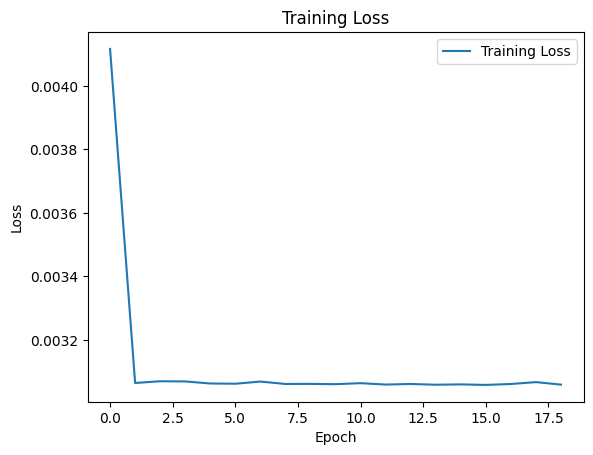

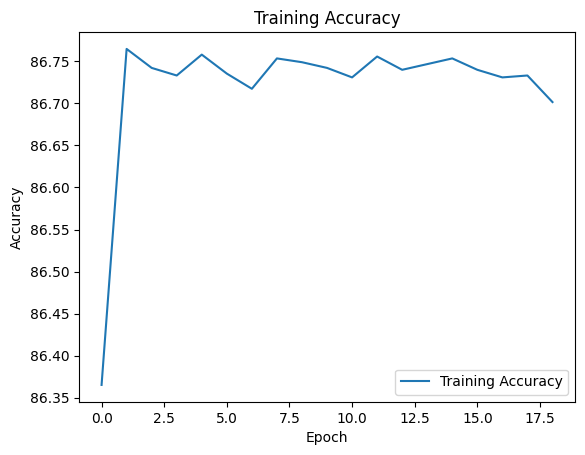

In [ ]:
import matplotlib.pyplot as plt

def plot_loss():
    plt.plot(lrLosses, label='Training Loss')
    plt.title('Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

def plot_accuracy():
    plt.plot(lrAccs, label='Training Accuracy')
    plt.title('Training Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

plot_loss()
plot_accuracy()


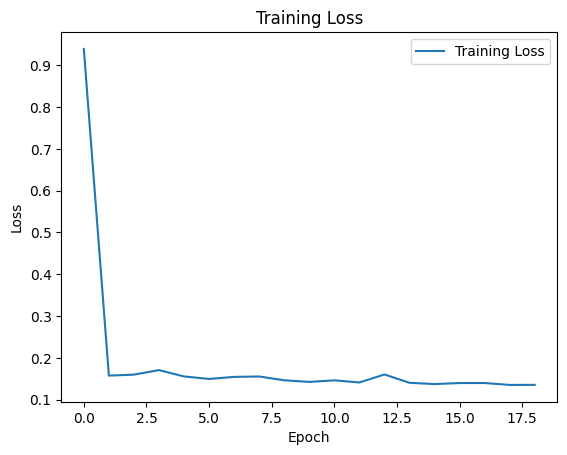

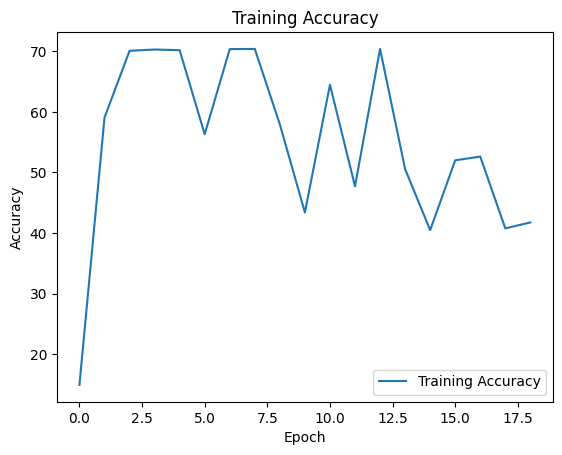

In [ ]:
import matplotlib.pyplot as plt

def plot_loss():
    plt.plot(cslr_1_losses, label='Training Loss')
    plt.title('Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

def plot_accuracy():
    plt.plot(cslr_1_Accs, label='Training Accuracy')
    plt.title('Training Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

plot_loss()
plot_accuracy()


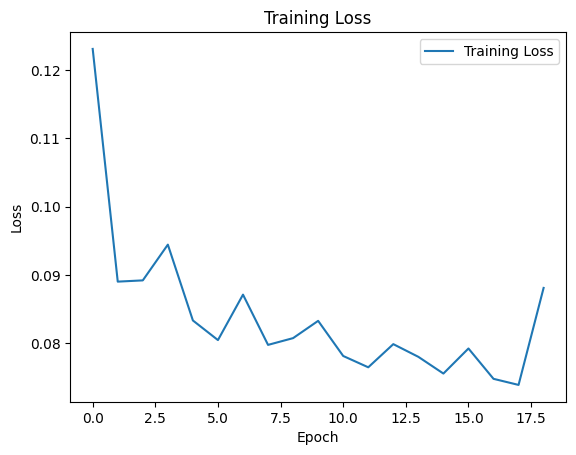

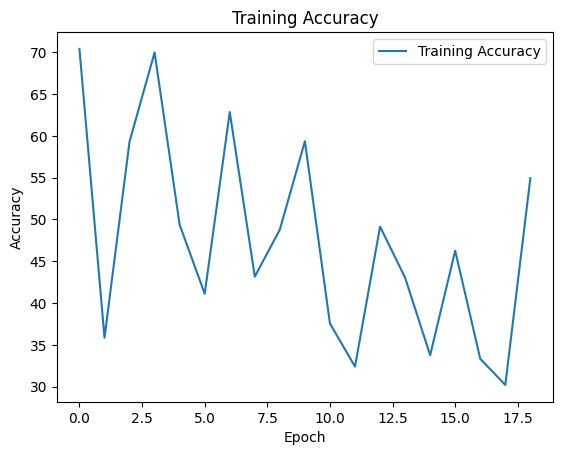

In [ ]:
import matplotlib.pyplot as plt

def plot_loss():
    plt.plot(cslr_2_losses, label='Training Loss')
    plt.title('Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

def plot_accuracy():
    plt.plot(cslr_2_Accs, label='Training Accuracy')
    plt.title('Training Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

plot_loss()
plot_accuracy()


# Nikou Gunnemann's Approach - Variation (A)

In [ ]:
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from sklearn.model_selection import train_test_split

X = df.drop(labels = ['Status','FNC'], axis = 1)
y = df['Status'].copy()

# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=14009)


In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np
from sklearn.preprocessing import StandardScaler

# Define a custom Dataset class
class CustomDataset(Dataset):
    def __init__(self, features, labels, costs):
        self.features = features
        self.labels = labels
        self.costs = costs

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx], self.costs[idx]

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32)

# Assuming costs are available, create a tensor (modify as needed)
costs_train = torch.tensor(np.random.uniform(1, 10, size=(y_train.shape[0],)), dtype=torch.float32)

# Create datasets
train_dataset = CustomDataset(X_train_tensor, y_train_tensor, costs_train)
test_dataset = CustomDataset(X_test_tensor, y_test_tensor, torch.ones_like(y_test_tensor))  # No costs in testing

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)


In [ ]:
import torch.nn as nn
from scipy.special import gammaincinv

class LogisticRegressionModel(nn.Module):
    def __init__(self, num_features):
        super(LogisticRegressionModel, self).__init__()
        self.linear = nn.Linear(num_features, 1)

    def forward(self, x):
        return torch.sigmoid(self.linear(x))

# Custom loss function for Variant A
def custom_loss_variant_a(outputs, targets, costs):
    # Binary cross-entropy loss
    bce_loss = F.binary_cross_entropy(outputs, targets.unsqueeze(1), reduction='none')
    # Weight the loss by costs
    weighted_loss = bce_loss.squeeze() * costs
    return weighted_loss.mean()

In [ ]:
# Initialize the model
model = LogisticRegressionModel(num_features=X_train.shape[1])
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
l=[]

# Training loop
num_epochs = 10
model.train()
for epoch in range(num_epochs):
    for features, labels, costs in train_loader:
        optimizer.zero_grad()
        outputs = model(features)
        loss = custom_loss_variant_a(outputs, labels, costs)
        loss.backward()
        optimizer.step()
    print(f'Epoch {epoch+1}, Loss: {loss.item()}')
    l.append(loss.item())

# Evaluate the model
model.eval()
a=[]
with torch.no_grad():
    correct = 0
    total = 0
    for features, labels, costs in test_loader:
        outputs = model(features)
        predicted = (outputs >= 0.5).float()
        total += labels.size(0)
        correct += (predicted.squeeze() == labels).sum().item()

accuracy = 100 * correct / total
print(f'Accuracy: {accuracy}%')
a.append(accuracy)

Epoch 1, Loss: 2.1959025859832764
Epoch 2, Loss: 1.0235761404037476
Epoch 3, Loss: 1.1922481060028076
Epoch 4, Loss: 1.6898778676986694
Epoch 5, Loss: 1.7369790077209473
Epoch 6, Loss: 1.4772262573242188
Epoch 7, Loss: 2.5496928691864014
Epoch 8, Loss: 1.5670645236968994
Epoch 9, Loss: 1.8901869058609009
Epoch 10, Loss: 1.6897515058517456
Accuracy: 86.76254769592016%


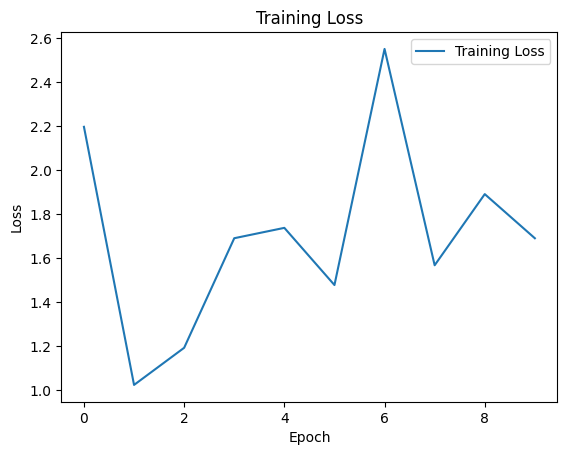

In [ ]:
import matplotlib.pyplot as plt

def plot_loss():
    plt.plot(l, label='Training Loss')
    plt.title('Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

plot_loss()